# Forecasting with machine learning

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

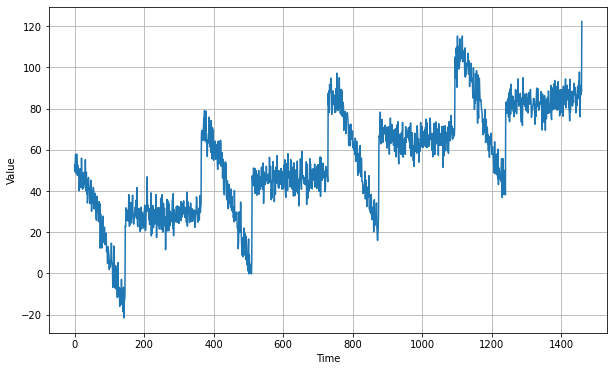

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 30-step windows for training.

In [4]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Linear Model

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

/home/ritesh/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Epoch 1/100
31/31 [==============================] - 1s 7ms/step - loss: 46.6813 - mae: 47.1784 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 11.9123 - mae: 12.4017 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 10.2063 - mae: 10.6947 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 9.8053 - mae: 10.2898 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 9.7068 - mae: 10.1940 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 9.5858 - mae: 10.0706 - val_loss: 9.2814 - val_mae: 9.7695
Epo

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 1ms/step - loss: 67.6867 - mae: 68.1863
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 52.3572 - mae: 52.8561
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 34.6465 - mae: 35.1446
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 17.6521 - mae: 18.1484
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 8.4604 - mae: 8.9488
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 7.9765 - mae: 8.4627
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 7.9201 - mae: 8.4035
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 7.8785 - mae: 8.3609
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 7.8191 - mae: 8.3014
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 7.7701 - mae: 8.2547
Epoch 11/100
31/31 [==============================]

(1e-06, 0.001, 0.0, 20.0)

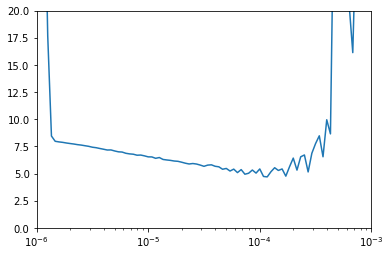

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

s 5ms/step - loss: 5.5355 - mae: 6.0157 - val_loss: 5.6318 - val_mae: 6.1172
Epoch 73/500
31/31 [==============================] - 0s 5ms/step - loss: 5.5398 - mae: 6.0224 - val_loss: 5.6279 - val_mae: 6.1140
Epoch 74/500
31/31 [==============================] - 0s 4ms/step - loss: 5.5468 - mae: 6.0275 - val_loss: 5.5921 - val_mae: 6.0779
Epoch 75/500
31/31 [==============================] - 0s 5ms/step - loss: 5.4855 - mae: 5.9659 - val_loss: 6.0816 - val_mae: 6.5651
Epoch 76/500
31/31 [==============================] - 0s 4ms/step - loss: 5.4834 - mae: 5.9646 - val_loss: 5.6142 - val_mae: 6.0898
Epoch 77/500
31/31 [==============================] - 0s 4ms/step - loss: 5.4842 - mae: 5.9646 - val_loss: 5.5331 - val_mae: 6.0186
Epoch 78/500
31/31 [==============================] - 0s 4ms/step - loss: 5.4070 - mae: 5.8878 - val_loss: 5.5209 - val_mae: 6.0072
Epoch 79/500
31/31 [==============================] - 0s 4ms/step - loss: 5.3568 - mae: 5.8389 - val_loss: 5.5470 - val_mae: 6.0356

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

In [12]:
lin_forecast.shape

(461,)

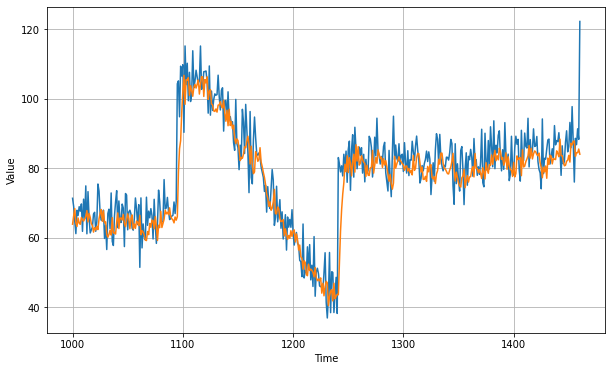

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [14]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.1662664

### Dense Model Forecasting

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/home/ritesh/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Epoch 1/100
31/31 [==============================] - 1s 1ms/step - loss: 43.8270 - mae: 44.3262
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 41.5210 - mae: 42.0202
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 38.6253 - mae: 39.1248
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 35.3203 - mae: 35.8201
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 31.5905 - mae: 32.0903
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 27.4033 - mae: 27.9022
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 22.7830 - mae: 23.2804
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 17.7632 - mae: 18.2594
Epoch 9/100
31/31 [===============

(1e-07, 0.005, 0.0, 30.0)

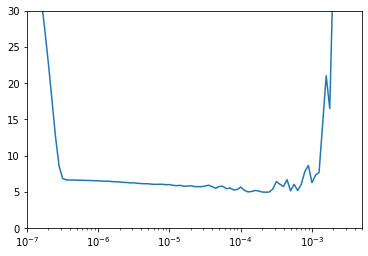

In [16]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

 22/500
31/31 [==============================] - 0s 5ms/step - loss: 5.9024 - mae: 6.3848 - val_loss: 5.6382 - val_mae: 6.1190
Epoch 23/500
31/31 [==============================] - 0s 5ms/step - loss: 5.8469 - mae: 6.3291 - val_loss: 5.9977 - val_mae: 6.4816
Epoch 24/500
31/31 [==============================] - 0s 5ms/step - loss: 5.8802 - mae: 6.3612 - val_loss: 5.6908 - val_mae: 6.1675
Epoch 25/500
31/31 [==============================] - 0s 4ms/step - loss: 5.7917 - mae: 6.2766 - val_loss: 5.6000 - val_mae: 6.0798
Epoch 26/500
31/31 [==============================] - 0s 6ms/step - loss: 5.8217 - mae: 6.3069 - val_loss: 5.5738 - val_mae: 6.0552
Epoch 27/500
31/31 [==============================] - 0s 6ms/step - loss: 5.7690 - mae: 6.2534 - val_loss: 5.7255 - val_mae: 6.2086
Epoch 28/500
31/31 [==============================] - 0s 5ms/step - loss: 5.8085 - mae: 6.2930 - val_loss: 5.5122 - val_mae: 5.9927
Epoch 29/500
31/31 [==============================] - 0s 4ms/step - loss: 5.7321 

In [18]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

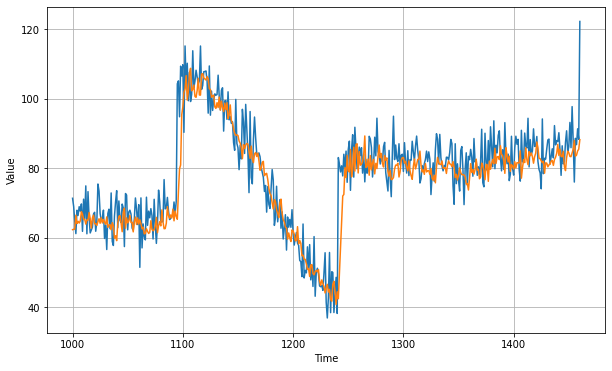

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [20]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

5.202555